# Chapter 9 Simple Normal Regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import requests
import seaborn as sns

from bambi import Prior
from plotnine import (
    aes,
    after_stat,
    geom_histogram,
    geom_line,
    geom_point,
    geom_smooth,
    ggplot,
    labs,
    stat_function,
)
from scipy import integrate
from scipy.stats import beta, binom, lognorm, norm, uniform

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%load_ext nb_black
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

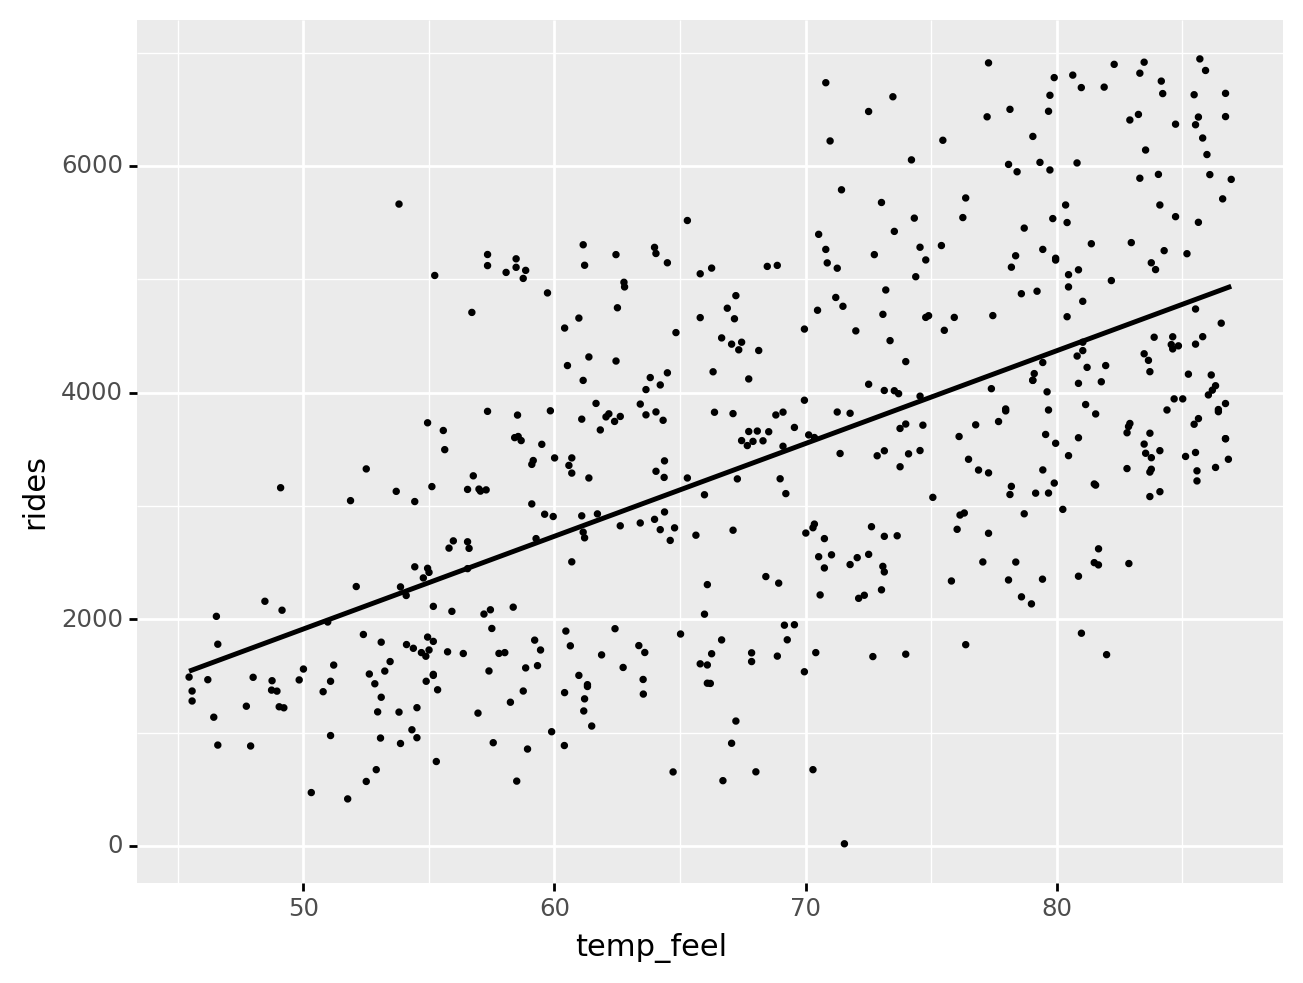

<ggplot: (380015986)>

<IPython.core.display.Javascript object>

In [2]:
data = pyreadr.read_r("data/bikes.rda")
bikes = data["bikes"]

(
    ggplot(bikes, aes(x="temp_feel", y="rides"))
    + geom_point(size=0.5)
    + geom_smooth(method="lm", se=False)
)

In [3]:
# prior_intercept = Prior("Gaussian", mu=5000, b=1000)
# prior_ = Prior("Gaussian", mu=100, b=40)
# prior_aux = Prior("Exponential", 0.0008)

# Set the prior when adding a term to the model; more details on this below.
# priors = {"1|uid": my_favorite_prior}
model = bmb.Model("rides ~ temp_feel", bikes)
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rides_sigma, temp_feel, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'temp_feel'}>,
        <AxesSubplot:title={'center':'temp_feel'}>],
       [<AxesSubplot:title={'center':'rides_sigma'}>,
        <AxesSubplot:title={'center':'rides_sigma'}>]], dtype=object)

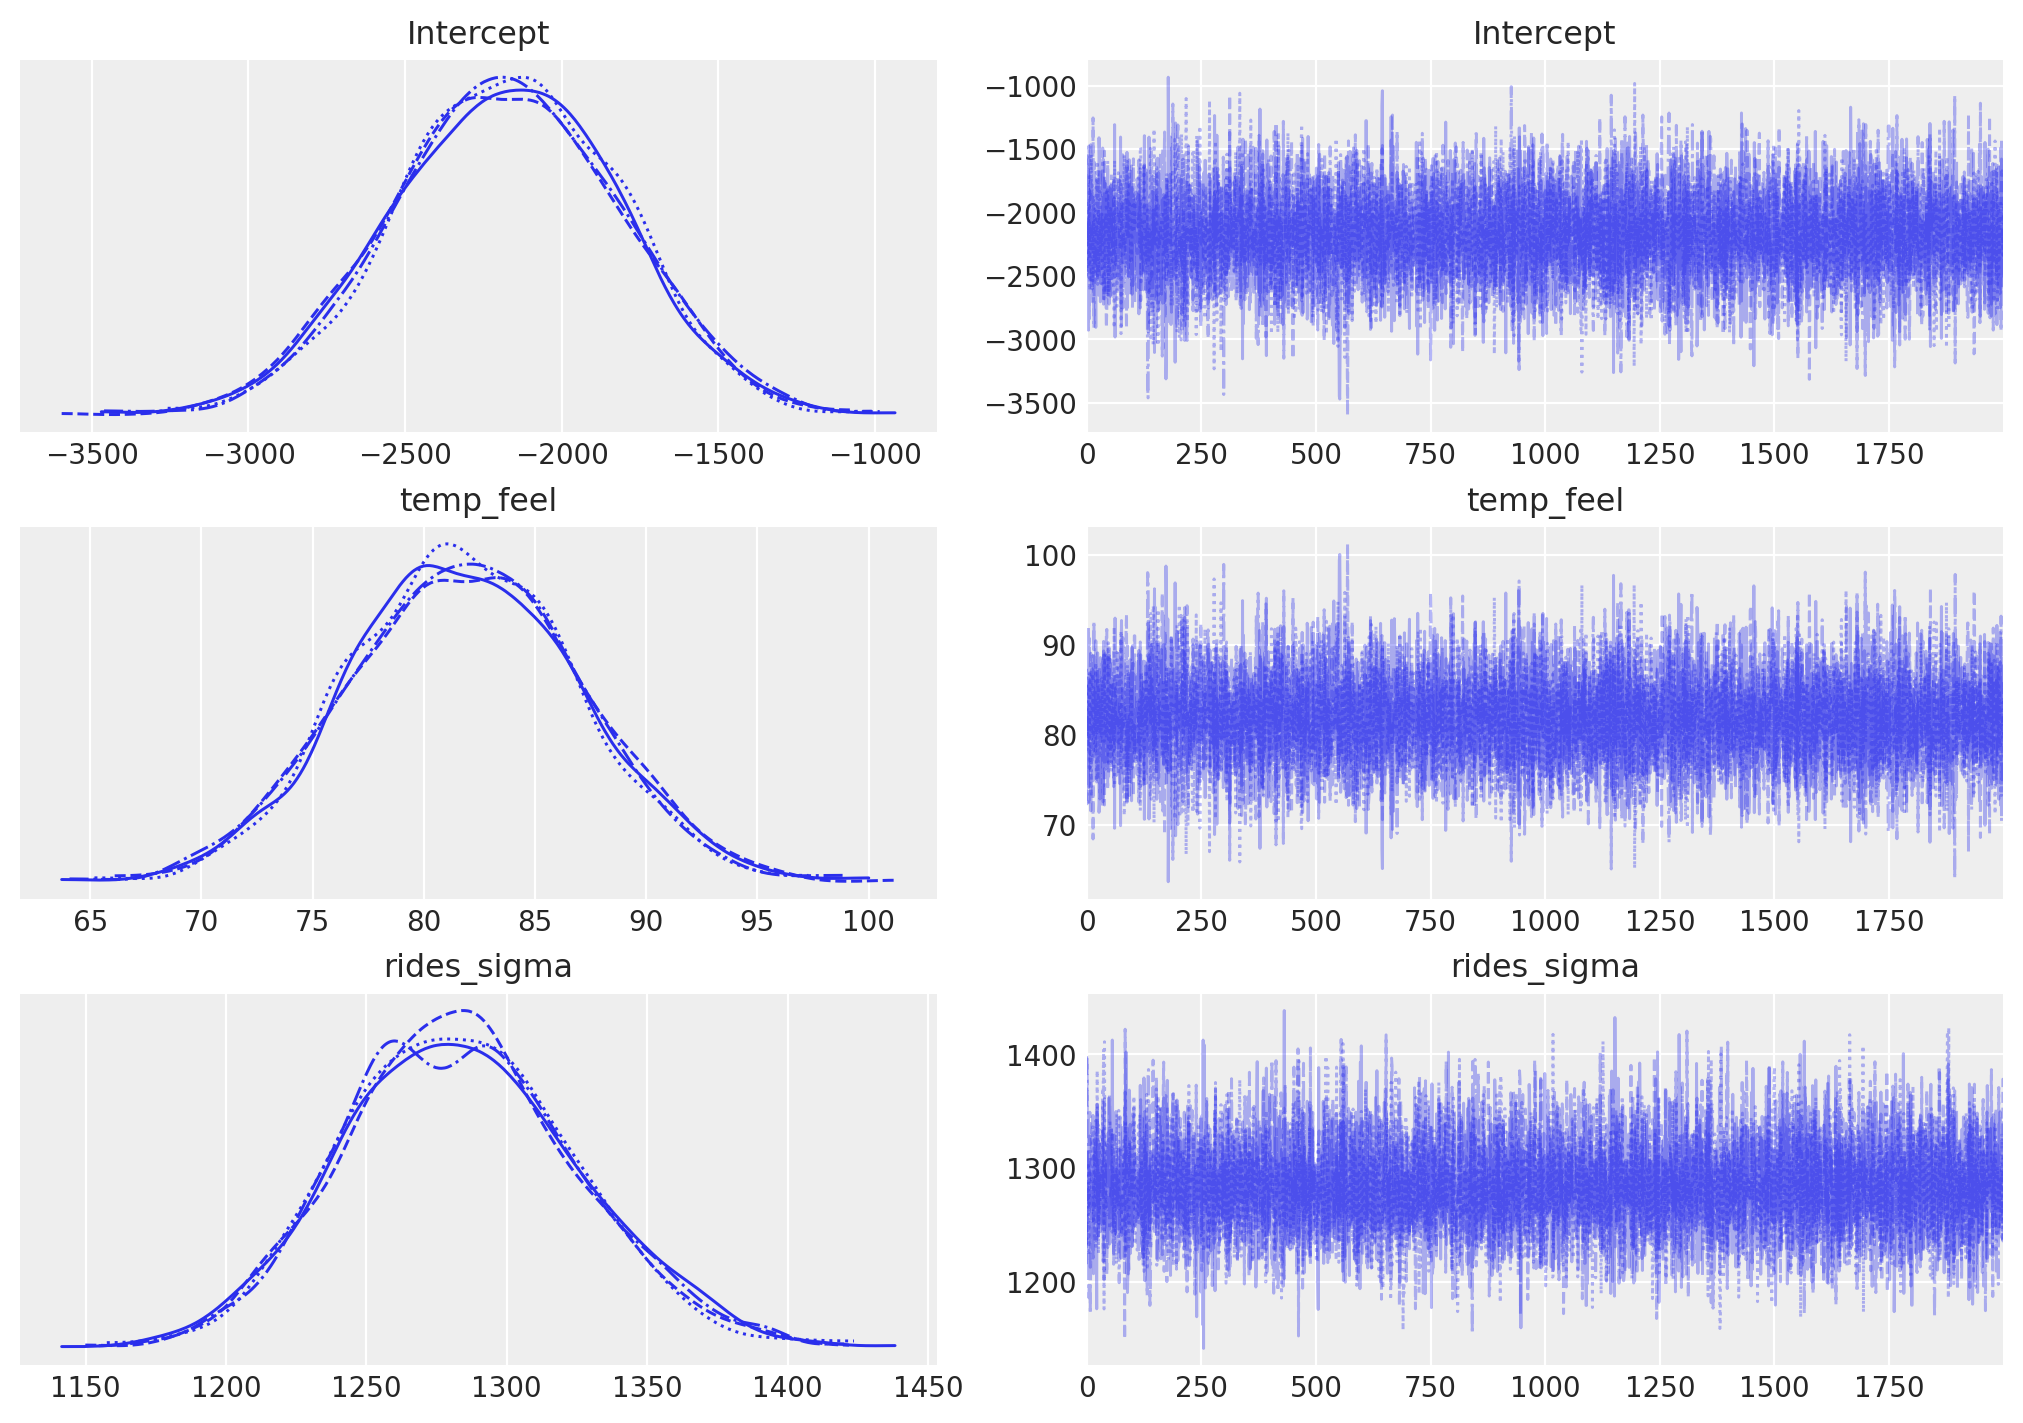

<IPython.core.display.Javascript object>

In [4]:
az.plot_trace(fitted, figsize=(10, 7))

In [5]:
data = data["bikes"]

<IPython.core.display.Javascript object>

In [14]:
num_samples = 2000
n_tune = 2000

with pm.Model() as simple_normal_model:
    beta_0 = pm.Normal("intercept", 5000, 1000)
    beta_1 = pm.Normal("beta", 100, 400)
    sigma = pm.Exponential("sigma", 0.0008)
    y = pm.Normal(
        "y",
        mu=beta_0 + beta_1 * np.asarray(data["temp_feel"]),
        sigma=sigma,
        observed=data["rides"],
    )
    trace = pm.sample(
        num_samples,
        tune=n_tune,
        chains=4,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
    )
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["intercept", "beta", "y"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/tomkealy/opt/anaconda3/envs/bayes_rules/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8978, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/1y/pyzwj_b548377277blj2d6xm0000gp/T/ipykernel_28473/2322583439.py:21: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

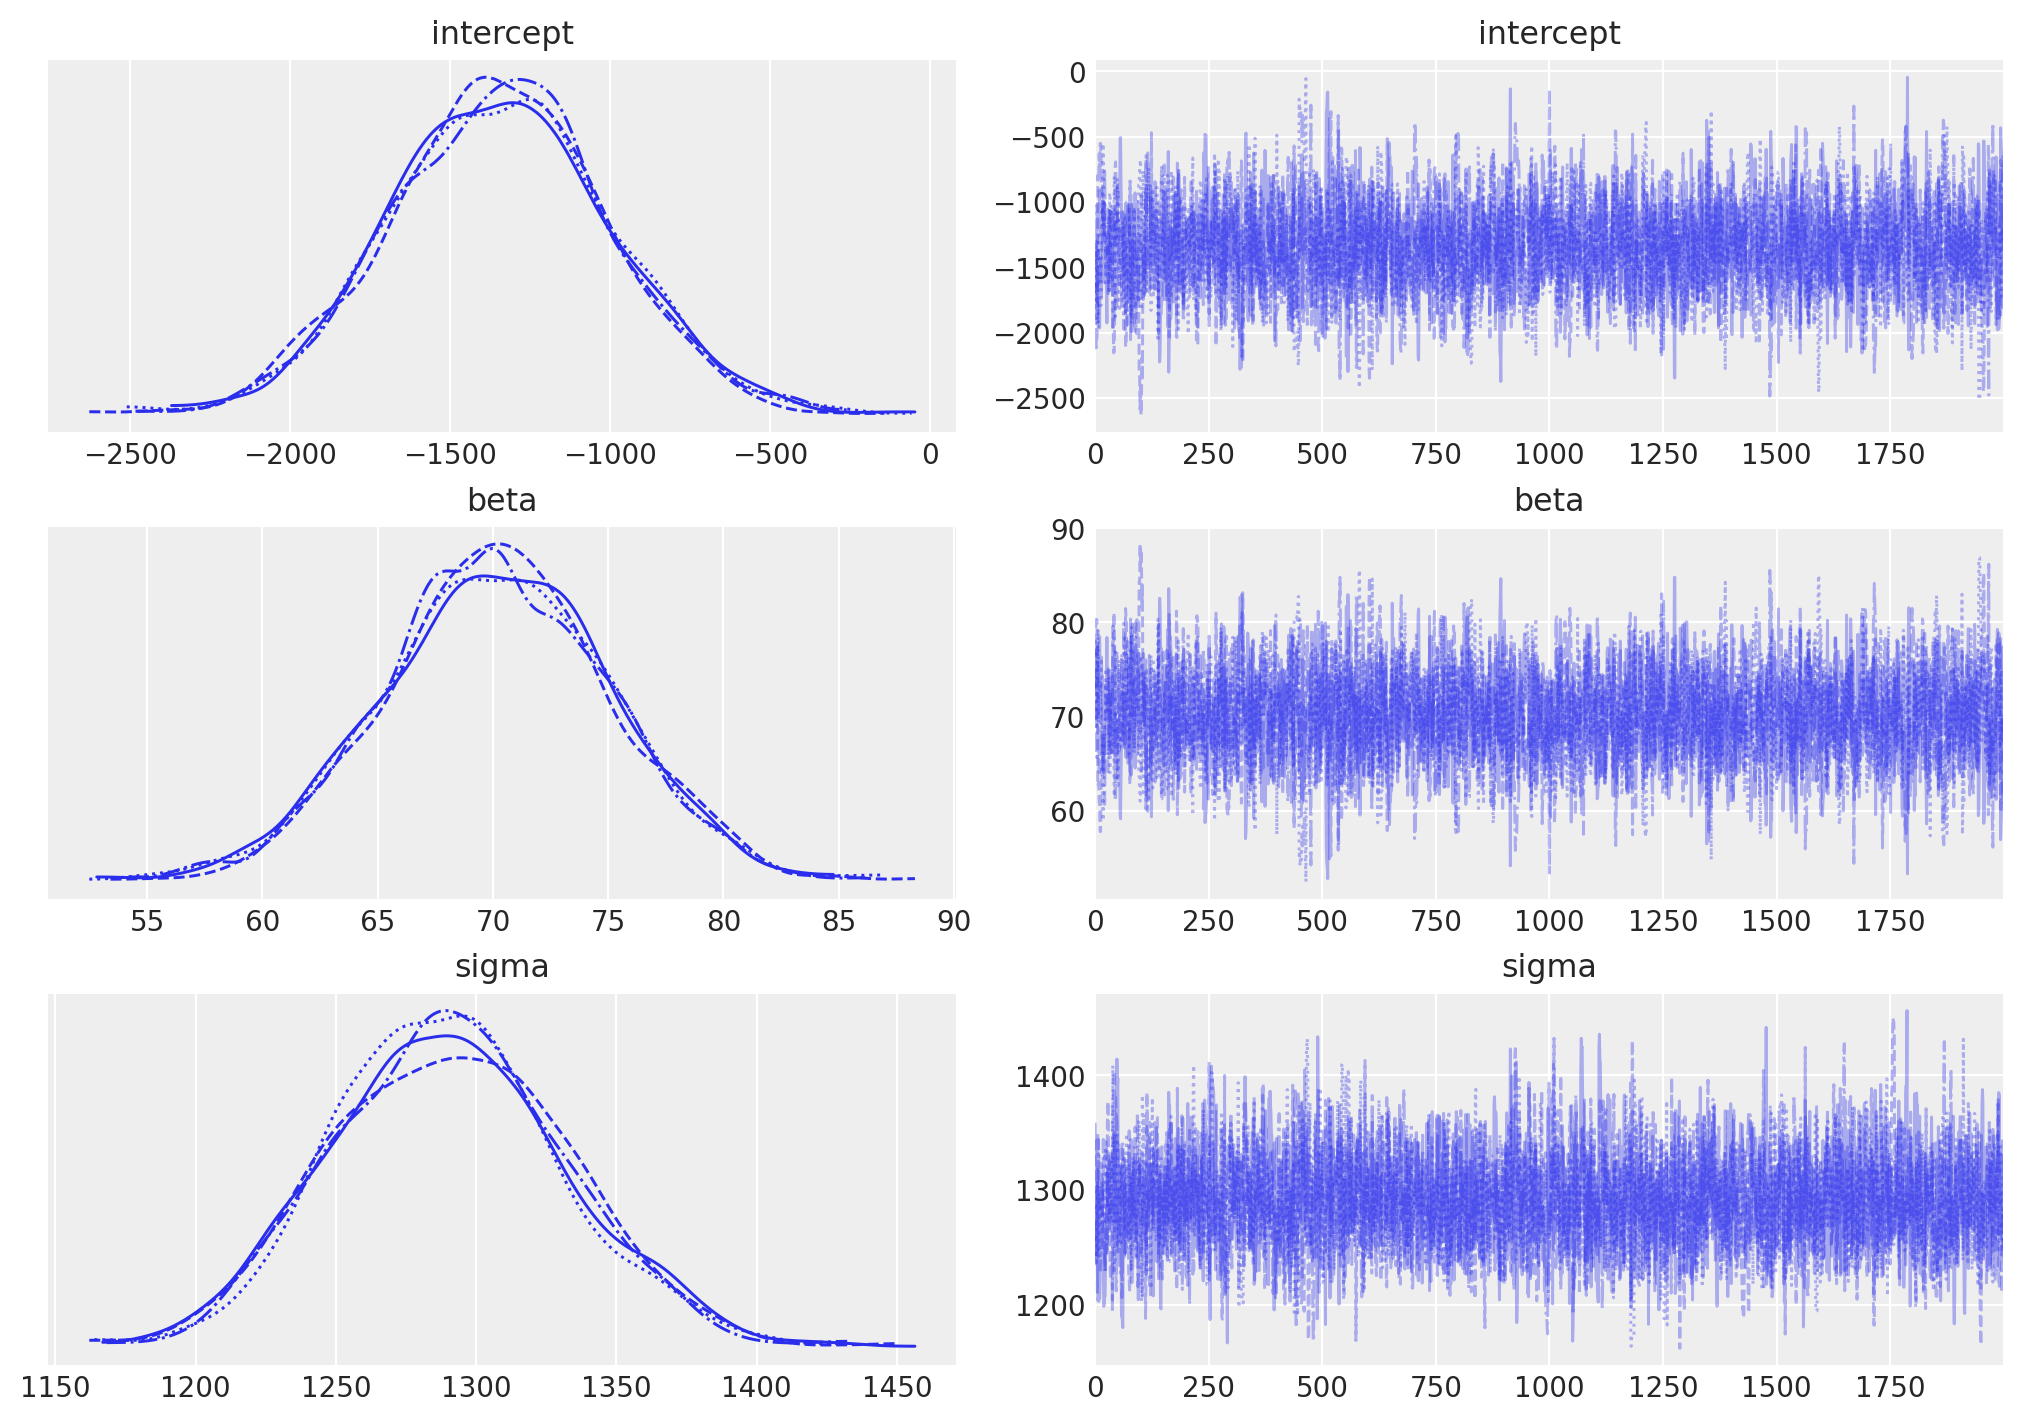

<IPython.core.display.Javascript object>

In [15]:
az.plot_trace(trace, figsize=(10, 7))

In [16]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2176.754,359.448,-2813.283,-1477.406,3.488,2.529,10642.0,5438.0,1.0
temp_feel,81.828,5.138,72.111,91.282,0.050,0.036,10625.0,5552.0,1.0
rides_sigma,1283.293,41.710,1206.466,1362.245,0.412,0.292,10319.0,5352.0,1.0


<IPython.core.display.Javascript object>

In [17]:
posterior_predictive = model.predict(fitted, kind="pps", draws=500)
fitted

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='rides / rides'>

/Users/tomkealy/opt/anaconda3/envs/bayes_rules/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


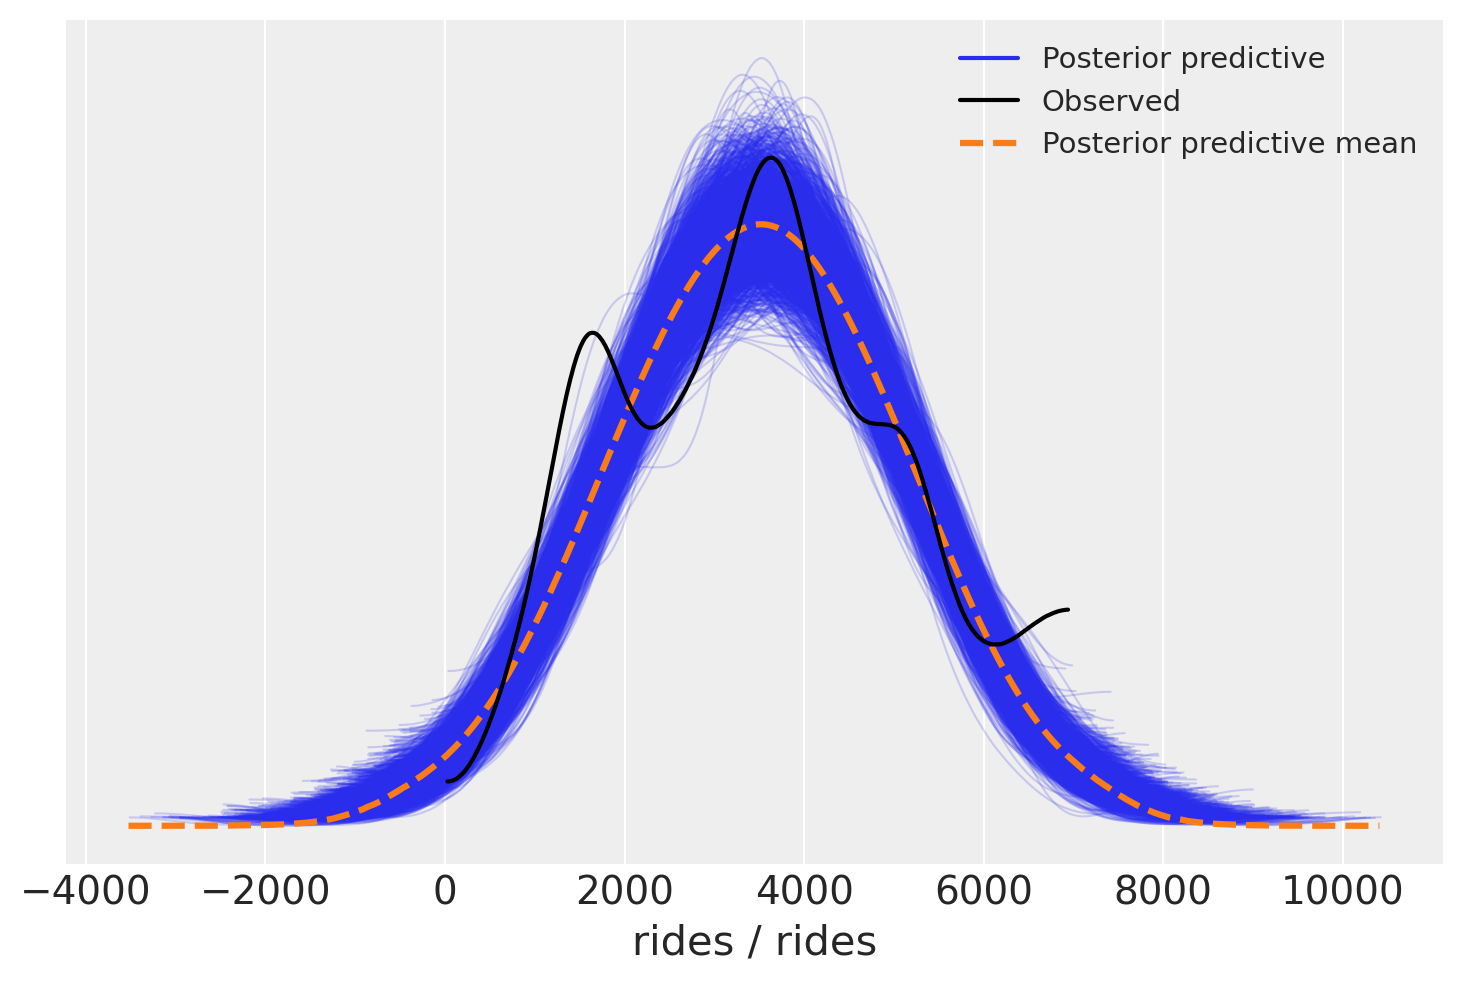

<IPython.core.display.Javascript object>

In [18]:
az.plot_ppc(fitted)

<AxesSubplot:xlabel='y / y'>

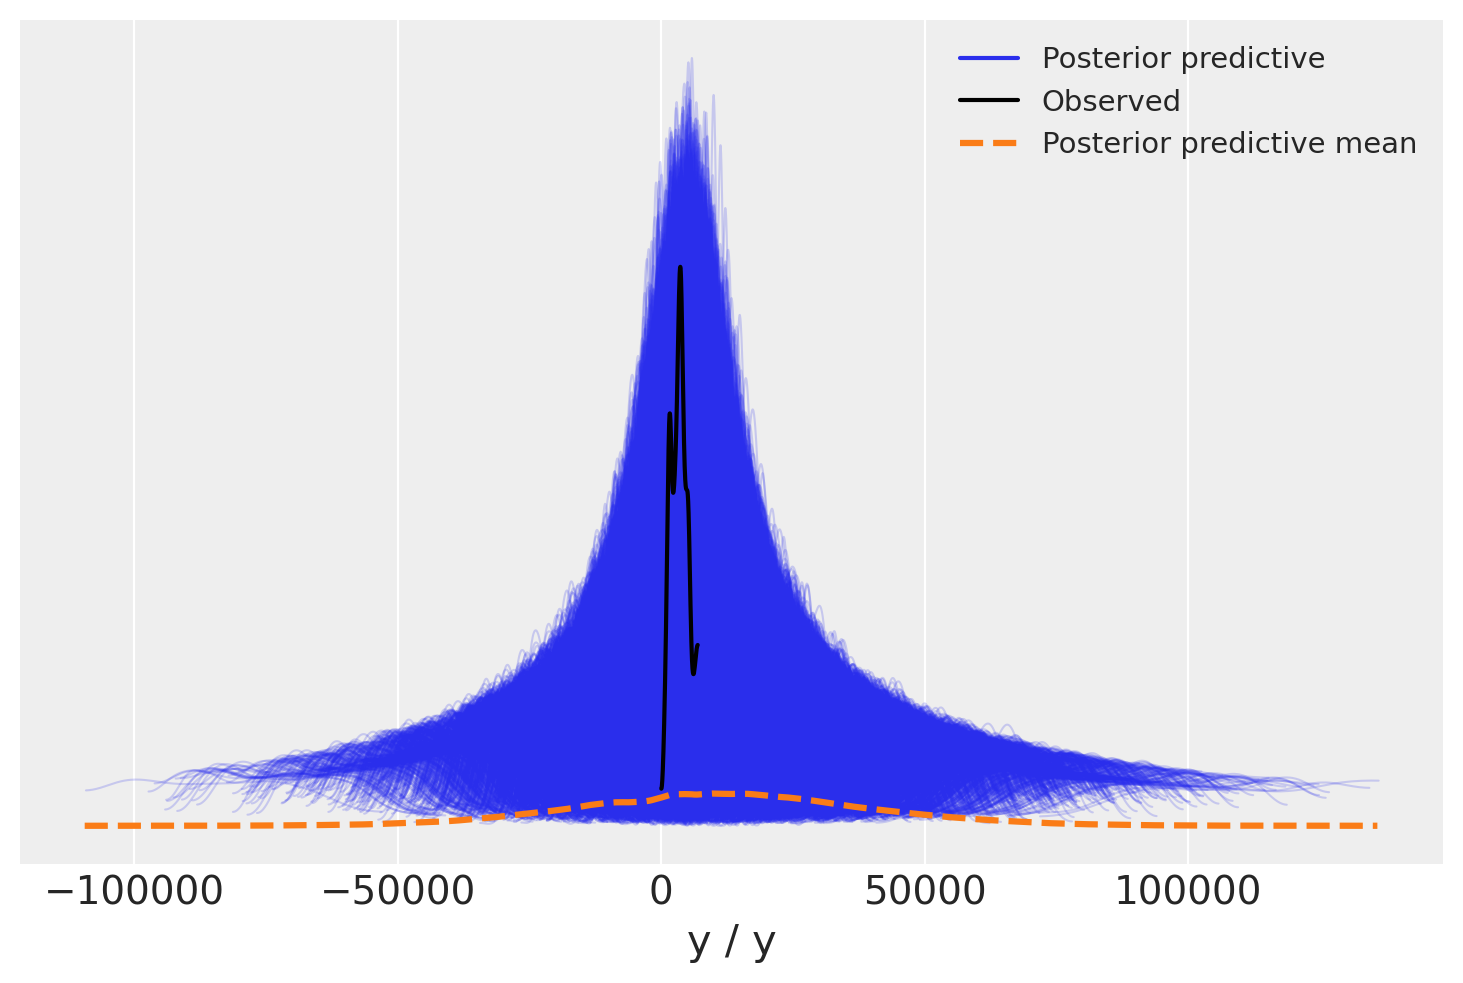

<IPython.core.display.Javascript object>

In [19]:
az.plot_ppc(ppc)

In [43]:
num_draws = 50
y = np.zeros(shape=(num_draws, data.shape[0]))
for i in range(num_draws):
    y[i, :] = (
        ppc.posterior_predictive.intercept.stack(sample=("chain", "draw")).values[i]
        + ppc.posterior_predictive.beta.stack(sample=("chain", "draw")).values[i]
        * data["temp_feel"]
    )

<IPython.core.display.Javascript object>

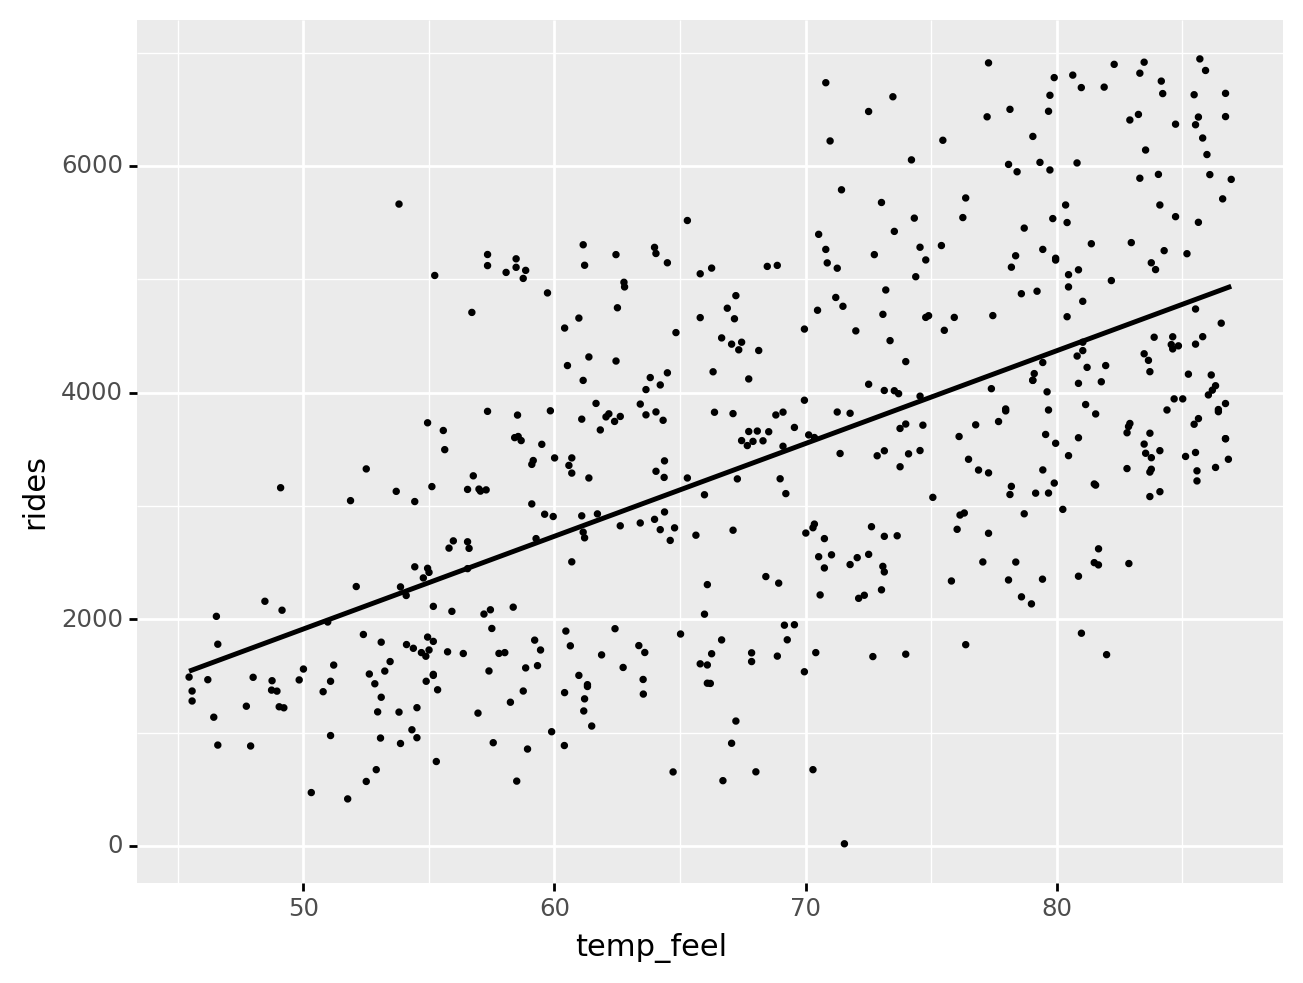

<ggplot: (421446560)>

<IPython.core.display.Javascript object>

In [50]:
(
    ggplot(bikes, aes(x="temp_feel", y="rides"))
    #     + geom_line(aes(y = .value, group = .draw), alpha = 0.15)
    + geom_point(size=0.5)
    + geom_smooth(method="lm", se=False)
)

In [53]:
exceed_0 = fitted.posterior.temp_feel.stack(sample=("chain", "draw")).values > 0
exceed_0.sum()

8000

<IPython.core.display.Javascript object>

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w